In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv("m_sand_concrete_dataset.csv")
df

,Cement,M_sand,Fly_ash,W_B_ratio,Water_reducer,Gravel,Compressive_strength,CPC
0,404.791210,716.707805,25.596509,0.319968,3.913121,1278.338629,228.661746,162.619943
1,337.775688,638.563169,93.604357,0.478330,3.975574,1231.632520,193.437545,154.611738
2,421.719584,548.381534,16.460782,0.343852,4.730135,1209.436235,205.165174,148.979534
3,389.473606,650.313433,4.491062,0.547399,1.266917,1251.394066,189.348505,160.160457
4,268.835470,545.693631,43.509706,0.393100,2.950379,1012.045390,154.693854,132.971430
...,...,...,...,...,...,...,...,...
81,331.277372,742.475442,24.783956,0.580782,4.007409,1252.597963,208.001125,157.217033
82,412.804077,595.141668,23.666236,0.341222,1.192764,1016.670375,201.796756,139.879017
83,283.394584,785.869819,74.601428,0.587664,4.247044,1084.183431,191.573191,148.668242
84,254.542415,587.275351,81.656876,0.540265,0.286160,1100.239012,165.576196,130.780271


In [36]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
yhat = iso.fit_predict(df)

# Giữ lại những hàng không phải outlier
mask = yhat != -1
df_clean = df[mask]
print("Kích thước trước khi lọc:", df.shape)
print("Kích thước sau khi lọc:", df_clean.shape)


Kích thước trước khi lọc: (86, 8)
Kích thước sau khi lọc: (81, 8)


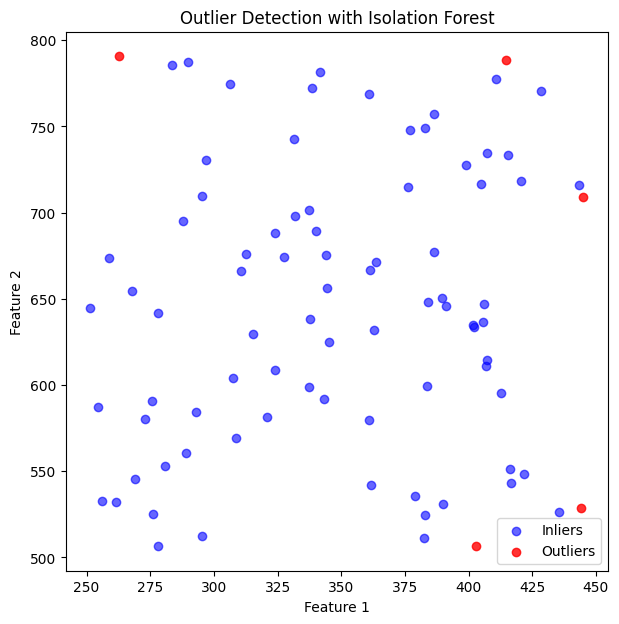

In [95]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Chỉ lấy 2 feature đầu tiên để trực quan
X = df.iloc[:, :2]

# Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
yhat = iso.fit_predict(X)

# -1 = outlier, 1 = inlier
mask = yhat != -1
X_inliers = X[mask]
X_outliers = X[~mask]

# Vẽ scatter
plt.figure(figsize=(7,7))
plt.scatter(X_inliers.iloc[:,0], X_inliers.iloc[:,1], c="blue", label="Inliers", alpha=0.6)
plt.scatter(X_outliers.iloc[:,0], X_outliers.iloc[:,1], c="red", label="Outliers", alpha=0.8)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Outlier Detection with Isolation Forest")
plt.legend()
plt.show()

In [6]:
df.columns

Index(['Cement', 'M_sand', 'Fly_ash', 'W_B_ratio', 'Water_reducer', 'Gravel',
       'Compressive_strength', 'CPC'],
      dtype='object')

In [96]:
df.describe()

,Cement,M_sand,Fly_ash,W_B_ratio,Water_reducer,Gravel,Compressive_strength,CPC
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,349.275167,645.260415,50.947998,0.441829,2.600906,1147.173062,194.896776,148.745499
std,55.227983,83.479393,30.094982,0.088375,1.528603,81.518412,17.279651,8.664164
min,251.472454,506.483624,1.393629,0.306344,0.027149,1010.817950,154.693854,130.119056
25%,299.160117,580.487641,23.364615,0.356017,1.219834,1081.776385,185.697437,141.801995
50%,344.680113,645.344265,51.259415,0.441101,2.843453,1151.932559,194.594935,149.793205
75%,400.951269,713.778328,78.292380,0.519780,3.911458,1210.433687,206.915821,154.602822
max,445.124470,790.752913,99.237556,0.593871,4.995524,1294.061435,230.989566,165.231150


In [97]:
X = df_clean.iloc[:, :6]   # feature
y = df_clean.iloc[:, 6:]   # label
# X = (X - X.min())/(X.max() - X.min())
# y = (y - y.min())/(y.max() - y.min())

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=None, shuffle=True
)

In [50]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [113]:
model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=300,          # nhiều cây nhưng sẽ dùng early stopping
        learning_rate=0.05,
        max_depth=3,               # cây nông hơn
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=5,              # tăng regularization
        reg_alpha=2,
        random_state=42
    )
)
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)

# Đánh giá cho từng label
r2_cs = r2_score(y_test.iloc[:,0], y_pred[:,0])
r2_cpc = r2_score(y_test.iloc[:,1], y_pred[:,1])
rmse_cs = mean_squared_error(y_test.iloc[:,0], y_pred[:,0])
rmse_cpc = mean_squared_error(y_test.iloc[:,0], y_pred[:,1])

print("CS - R²:", r2_cs, " RMSE:", rmse_cs)
print("CPC - R²:", r2_cpc, " RMSE:", rmse_cpc)

CS - R²: 0.8098159199026208  RMSE: 56.958806800398584
CPC - R²: 0.6042279108127374  RMSE: 2108.317924238905


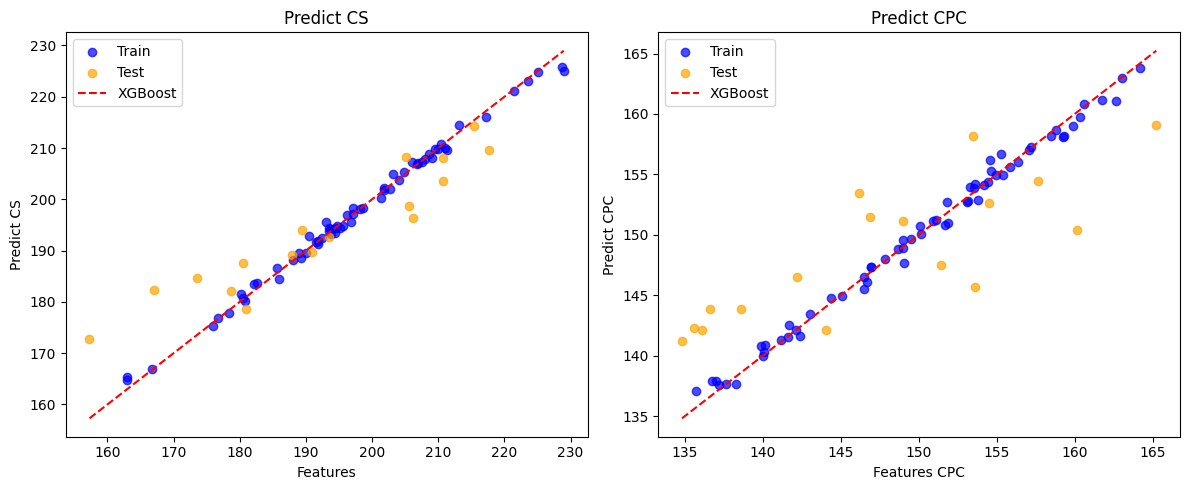

In [117]:

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

plt.figure(figsize=(12,5))

# --- Scatter plot cho CS ---
plt.subplot(1,2,1)
plt.scatter(y_train.iloc[:,0], y_pred_train[:,0], alpha=0.7, color="blue", label="Train")
plt.scatter(y_test.iloc[:,0], y_pred_test[:,0], alpha=0.7, color="orange", label="Test")
plt.plot([min(y_train.iloc[:,0].min(), y_test.iloc[:,0].min()),
          max(y_train.iloc[:,0].max(), y_test.iloc[:,0].max())],
         [min(y_train.iloc[:,0].min(), y_test.iloc[:,0].min()),
          max(y_train.iloc[:,0].max(), y_test.iloc[:,0].max())],
         'r--', label="XGBoost")
plt.xlabel("Features")
plt.ylabel("Predict CS")
plt.title("Predict CS")
plt.legend()

# --- Scatter plot cho CPC ---
plt.subplot(1,2,2)
plt.scatter(y_train.iloc[:,1], y_pred_train[:,1], alpha=0.7, color="blue", label="Train")
plt.scatter(y_test.iloc[:,1], y_pred_test[:,1], alpha=0.7, color="orange", label="Test")
plt.plot([min(y_train.iloc[:,1].min(), y_test.iloc[:,1].min()),
          max(y_train.iloc[:,1].max(), y_test.iloc[:,1].max())],
         [min(y_train.iloc[:,1].min(), y_test.iloc[:,1].min()),
          max(y_train.iloc[:,1].max(), y_test.iloc[:,1].max())],
         'r--', label="XGBoost")
plt.xlabel("Features CPC")
plt.ylabel("Predict CPC")
plt.title("Predict CPC")
plt.legend()

plt.tight_layout()
plt.show()


In [46]:
# mean_squared_error(cs, xgb.predict(cm)), r2_score(cs, xgb.predict(cm)), mean_absolute_error(cs, xgb.predict(cm))

(0.013960547619908312, 0.7246327466634186, 0.0883530303650752)

In [116]:
print("R² label 1:", r2_score(y_test.iloc[:,0], y_pred_test[:,0]))
print("R² label 2:", r2_score(y_train.iloc[:,0], y_pred_train[:,0]))

R² label 1: 0.8098159199026208
R² label 2: 0.9941067275665735
